In [44]:
import pandas as pd
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Datasets/cleaned_electricity_data.csv', header=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [2]:
pip install imbalanced-learn

In [35]:
X = data.drop(columns=['CONS_NO', 'FLAG'])
y = data['FLAG']

In [36]:
X = data[['total_consumption']]

# SVM Data pre-processing

In [37]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

print("Original training set shape:", X_train.shape)
print("Resampled training set shape:", X_train_resampled.shape)

Original training set shape: (33893, 1)
Resampled training set shape: (62076, 1)


In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_resampled_scaled = scaler.transform(X_test_resampled)



# Training

In [39]:

svm = OneClassSVM(nu=0.1, kernel='rbf', gamma='auto')
svm.fit(X_train_resampled_scaled)


predictions = svm.predict(X_test_resampled_scaled)


predictions = [0 if p == 1 else 1 for p in predictions]


In [40]:

print("Confusion Matrix:")
print(confusion_matrix(y_test_resampled, predictions))
print("\nClassification Report:")
print(classification_report(y_test_resampled, predictions))

Confusion Matrix:
[[6909  808]
 [6932  785]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.90      0.64      7717
           1       0.49      0.10      0.17      7717

    accuracy                           0.50     15434
   macro avg       0.50      0.50      0.40     15434
weighted avg       0.50      0.50      0.40     15434



In [46]:
decision_scores = svm.decision_function(X_test_resampled_scaled)
threshold = np.percentile(decision_scores, 90)  # Adjust the percentile for anomalies
predictions = (decision_scores < threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test_resampled, predictions))
print("\nClassification Report:")
print(classification_report(y_test_resampled, predictions))

Confusion Matrix:
[[ 645 7072]
 [ 899 6818]]

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.08      0.14      7717
           1       0.49      0.88      0.63      7717

    accuracy                           0.48     15434
   macro avg       0.45      0.48      0.39     15434
weighted avg       0.45      0.48      0.39     15434



In [47]:
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test_resampled)

svm_normal = OneClassSVM(nu=0.1, kernel='rbf', gamma='auto')
svm_normal.fit(X_train_scaled)

normal_predictions = svm_normal.predict(X_test_resampled_scaled)
normal_predictions = [0 if p == 1 else 1 for p in normal_predictions]


svm_anomaly = OneClassSVM(nu=0.1, kernel='rbf', gamma='auto')
svm_anomaly.fit(X_train_scaled)

# Decision scores and threshold-based anomaly predictions
anomaly_decision_scores = svm_anomaly.decision_function(X_test_resampled_scaled)
threshold = np.percentile(anomaly_decision_scores, 90)  # Adjust threshold for anomalies
anomaly_predictions = (anomaly_decision_scores < threshold).astype(int)

# Combine predictions
final_predictions = []
for i in range(len(normal_predictions)):
    if normal_predictions[i] == 0:
        final_predictions.append(0)
    else:
        final_predictions.append(anomaly_predictions[i])


print("Confusion Matrix:")
print(confusion_matrix(y_test_resampled, final_predictions))
print("\nClassification Report:")
print(classification_report(y_test_resampled, final_predictions))

Confusion Matrix:
[[6909  808]
 [6932  785]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.90      0.64      7717
           1       0.49      0.10      0.17      7717

    accuracy                           0.50     15434
   macro avg       0.50      0.50      0.40     15434
weighted avg       0.50      0.50      0.40     15434



# Testing

In [2]:

final_predictions = []

for i in range(len(y_test_resampled)):
    if y_test_resampled[i] == 0:  # If the true label is normal
        final_predictions.append(normal_predictions[i])  # Use the normal SVM predictions
    else:  # If the true label is anomaly
        final_predictions.append(anomaly_predictions[i])  # Use the anomaly SVM predictions


print("Confusion Matrix:")
print(confusion_matrix(y_test_resampled, final_predictions))
print("\nClassification Report:")
print(classification_report(y_test_resampled, final_predictions))


NameError: name 'y_test_resampled' is not defined

# Visualization

In [1]:

magnitude_threshold = np.mean(X_test_resampled_scaled) + 3 * np.std(X_test_resampled_scaled)

# Filter anomalies by magnitude
significant_anomalies = [
    i for i in anomaly_indices if X_test_resampled_scaled[i] > magnitude_threshold
]


plt.figure(figsize=(12, 6))

# Plot total consumption as a line for all data points
plt.plot(range(len(X_test_resampled_scaled)), X_test_resampled_scaled, color='blue', alpha=0.6, label='Total Consumption (Normal)')


plt.scatter(
    significant_anomalies,
    [X_test_resampled_scaled[i] for i in significant_anomalies],
    color='red',
    label='Significant Anomaly',
    marker='o',
    s=50
)


plt.title('Total Consumption with Anomalies Highlighted')
plt.xlabel('Index')
plt.ylabel('Total Consumption (Standardized)')
plt.legend()
plt.grid()
plt.show()

NameError: name 'np' is not defined

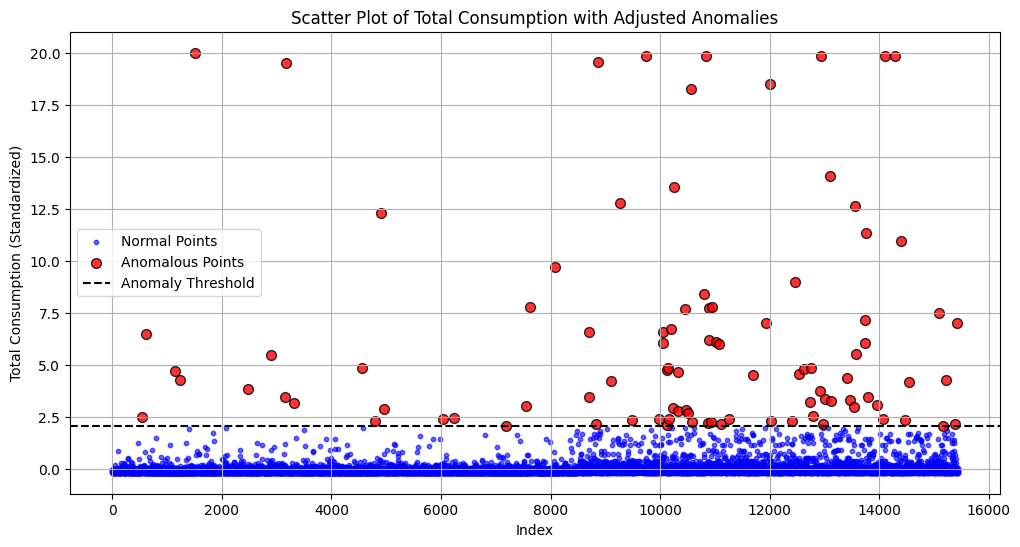

In [65]:
import numpy as np
import matplotlib.pyplot as plt

adjusted_predictions = np.array(final_predictions)
adjusted_predictions[total_consumption < threshold] = 0

adjusted_normal_indices = np.where(adjusted_predictions == 0)[0]
adjusted_anomaly_indices = np.where(adjusted_predictions == 1)[0]

plt.figure(figsize=(12, 6))

# Plot normal points
plt.scatter(
    indices[adjusted_normal_indices],
    total_consumption[adjusted_normal_indices],
    color='blue',
    alpha=0.6,
    label='Normal Points',
    s=10
)

# Plot anomalies above the threshold
plt.scatter(
    indices[adjusted_anomaly_indices],
    total_consumption[adjusted_anomaly_indices],
    color='red',
    alpha=0.8,
    label='Anomalous Points',
    s=50,
    edgecolor='black'
)

# Add threshold line
plt.axhline(y=threshold, color='black', linestyle='--', label='Anomaly Threshold')


plt.title('Scatter Plot of Total Consumption with Adjusted Anomalies')
plt.xlabel('Index')
plt.ylabel('Total Consumption (Standardized)')
plt.legend()
plt.grid()
plt.show()

# Data Visualization

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def explore_smart_grid_data(df):
    """
    Comprehensive exploration of smart grid dataset

    Parameters:
    df: pandas DataFrame containing smart grid data
    """
    # Basic dataset information
    print("\n=== Dataset Overview ===")
    print(f"Dataset Shape: {df.shape}")
    print(f"\nColumns available:")
    print(df.columns.tolist())
    print("\nData types of columns:")
    print(df.dtypes)

    # Class distribution
    if 'label' in df.columns:
        print("\n=== Class Distribution ===")
        class_dist = df['label'].value_counts(normalize=True) * 100
        print("\nClass distribution (%):")
        print(class_dist)
        print(f"\nTotal number of customers: {df['customer_id'].nunique() if 'customer_id' in df.columns else 'N/A'}")

        # Distribution by customer
        if 'customer_id' in df.columns:
            customer_labels = df.groupby('customer_id')['label'].first()
            print(f"\nNumber of customers by class:")
            print(customer_labels.value_counts())

    # Missing values
    print("\n=== Missing Values ===")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing values by column:")
        print(missing[missing > 0])
    else:
        print("No missing values found")

    # Time period analysis
    time_cols = df.select_dtypes(include=['datetime64']).columns
    if len(time_cols) > 0:
        print("\n=== Time Period Analysis ===")
        for col in time_cols:
            print(f"\nTime range for {col}:")
            print(f"Start: {df[col].min()}")
            print(f"End: {df[col].max()}")
            print(f"Time span: {df[col].max() - df[col].min()}")

    # Basic statistics for numerical columns
    print("\n=== Numerical Columns Statistics ===")
    print(df.describe())

    return df.describe()

explore_smart_grid_data(data)


=== Dataset Overview ===
Dataset Shape: (42367, 1037)

Columns available:
['CONS_NO', 'FLAG', '2014/1/1', '2014/1/10', '2014/1/11', '2014/1/12', '2014/1/13', '2014/1/14', '2014/1/15', '2014/1/16', '2014/1/17', '2014/1/18', '2014/1/19', '2014/1/2', '2014/1/20', '2014/1/21', '2014/1/22', '2014/1/23', '2014/1/24', '2014/1/25', '2014/1/26', '2014/1/27', '2014/1/28', '2014/1/29', '2014/1/3', '2014/1/30', '2014/1/31', '2014/1/4', '2014/1/5', '2014/1/6', '2014/1/7', '2014/1/8', '2014/1/9', '2014/10/1', '2014/10/10', '2014/10/11', '2014/10/12', '2014/10/13', '2014/10/14', '2014/10/15', '2014/10/16', '2014/10/17', '2014/10/18', '2014/10/19', '2014/10/2', '2014/10/20', '2014/10/21', '2014/10/22', '2014/10/23', '2014/10/24', '2014/10/25', '2014/10/26', '2014/10/27', '2014/10/28', '2014/10/29', '2014/10/3', '2014/10/30', '2014/10/31', '2014/10/4', '2014/10/5', '2014/10/6', '2014/10/7', '2014/10/8', '2014/10/9', '2014/11/1', '2014/11/10', '2014/11/11', '2014/11/12', '2014/11/13', '2014/11/14', '20

,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9,total_consumption
count,42367.000000,42367.00000,42367.000000,42367.00000,42367.000000,42367.000000,42367.000000,42367.000000,42367.000000,42367.000000,...,42367.000000,42367.000000,42367.000000,42367.000000,42367.000000,42367.000000,42367.000000,42367.000000,42367.000000,4.236700e+04
mean,0.085255,4.37735,4.253246,4.14905,4.332815,6.431958,4.415586,4.490648,4.381144,4.185422,...,9.110292,10.643937,9.656857,11.051918,11.349035,11.514183,11.215779,10.931607,10.605848,7.119822e+03
std,0.279264,26.89872,31.478885,30.15485,25.252658,450.792440,27.367051,28.823352,29.087551,23.885179,...,56.480141,87.575902,61.136524,93.760733,100.388346,117.651884,103.405300,100.235209,106.831143,3.470716e+04
min,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.610000,0.760000,0.550000,0.770000,0.790000,0.790000,0.810000,0.810000,0.800000,1.257270e+03
50%,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.510000,4.910000,4.600000,5.040000,5.010000,5.070000,5.020000,4.950000,4.860000,3.847710e+03
75%,0.000000,5.08000,4.560000,4.64000,5.050000,5.100000,5.040000,5.240000,4.990000,5.000000,...,9.240000,10.655000,9.520000,11.290000,11.300000,11.490000,11.200000,10.675000,10.230000,7.784150e+03
max,1.000000,3318.00000,3966.000000,4392.00000,3414.000000,92713.900000,3167.000000,3960.000000,3654.000000,3306.000000,...,6990.000000,14640.000000,6672.000000,16320.000000,17100.000000,21210.000000,17940.000000,16710.000000,18570.000000,4.080330e+06
